In [638]:
import pandas as pd
import numpy as np
import math
import statsmodels.formula.api as sm
import statsmodels.api         as sma
from statsmodels.graphics.regressionplots import plot_fit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

In [639]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')


In [640]:
#FUNÇÃO PARA CALCULAR O VIF
def calc_vif(dataframe):
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

#FUNÇÃO PARA EXIBIS AS MÉTRICAS DO MODELO
def imprimir_metricas (y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

<h2> 1. Lendo a base </h2>

In [641]:
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')
#df = df.drop(['MES_LAN', 'AGENTE', 'DATA_ENT', 'ZONA'], axis=1)

In [642]:
df.columns

Index(['Unnamed: 0.1', 'ID', 'TIPO_EMP', 'MES_LAN', 'ANO_LAN', 'DATA_ENT',
       'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'DORM_UNID',
       'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'BLOCOS', 'UNIDAND', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'DORM_EMP',
       'BANH_EMP', 'GAR_EMP', 'AU_EMP', 'AT_EMP', 'PC_TT_UN', 'PC_M2_AU',
       'PC_M2_AT', 'PC_TT_ATU', 'PC_AU_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'SIST_FINAN',
       'AGENTE', 'INCORPORAD', 'CONSTRUTOR', 'INCORPOR_A', 'CONSTRUT_A',
       'COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT', 'AP2010', 'SC_2010',
       'RENRESP91', 'RENRESP00', 'RENRESP10', 'PCMEDAU91', 'PCMEDAU00',
       'PCMEDAU10', 'BANH_DORM', 'Unnamed: 0', 'Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 mo

In [643]:
df.columns
df_rf = df.drop(['Unnamed: 0.1', 'Unnamed: 0','RENRESP91', 'PCMEDAU00',
       'PCMEDAU10', 'RENRESP00', 'ID', 'AGENTE', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'PC_TT_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'PC_M2_AT_log', 'VLR_US__CO_log', 'PCMEDAU10_log', 'PCMEDAU91', 'PC_M2_AU_log', 'PC_AU_ATU'], axis=1)

df['AR_UT_UNID_log'] = np.log(df['AR_UT_UNID'])
df['RENRESP10_log'] = np.log(df['RENRESP10'])

<h3>1.1 Definindo as variáveis que estarão presentes no modelo</h3>

In [644]:
target_au = 'PC_AU_ATU_log'
target_tt = 'PC_TT_ATU_log'
numericas = ['ANO_LAN', 'DORM_UNID', 'BANH_DORM', 'AR_UT_UNID']
categoricas = ['REGIAO', 'TIPO_EMP', 'AGENTE', 'CONSTRUTOR']
features = numericas + categoricas
#['', 'ANO_LAN', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID']
v_ibge = ['Total de filhos dos responsáveis de domicílios', 'PERC_ALUGADOS',
       'PERC_UNIPESSOAIS', 'PERC_2_3_MORADORES', 'PERC_BRANCOS', 'PERC_PPI']

numericas2 = df_rf.select_dtypes(['int', 'float']).columns
numericas2 = numericas2.drop(['PC_AU_ATU_log', 'PC_TT_ATU_log'])
categoricas2 = df_rf.select_dtypes(['object', 'string']).columns


In [645]:
for col in categoricas2:
    df[col] = df[col].fillna(df[col].mode())

#df['REGIAO'] = df['REGIAO'].fillna(df['REGIAO'].mode())

In [646]:
for col in categoricas:
    df[col] = LabelEncoder().fit_transform(df[col].array.reshape(-1, 1))

C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

<h2>2. Fazendo os modelos de regressão </h2>

In [647]:
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop([target_au, target_tt], axis=1), df_rf[target_au], test_size=0.2)

<h3>2.1 Modelo de regressão linear </h3>
O modelo de regressão linear permite maior interpretabilidade das variáveis e da constituição do preço dos empreendimentos lançados. Contém alguma perda de performance em relação aos modelos mais avançados, como ensembles de Random Forest, mas são mais facilmente lidos.

<h3>2.1.1 - Criando o baseline</h3>
<>No modelo baseline foram consideradas variáveis que são intuitivamente conhecidas na descrição de um empreendimento imobiliário, como o número de dormitórios, o número de banheiros e a área do apartamento. <>

In [648]:
rl_baseline = sm.ols(formula='PC_AU_ATU ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
rl_baseline_log = sm.ols(formula='PC_AU_ATU_log ~ DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()

rl_baseline_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     988.9
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:20:36   Log-Likelihood:                -7542.7
No. Observations:               13548   AIC:                         1.509e+04
Df Residuals:                   13544   BIC:                         1.512e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4920      0.012    679.921      0.000       8.467       8.516
DORM_UNID     -0.2387      0.007    -33.706      0.000      -0.253      -0.225
BANH_UNID      0.2434      0.009     27.590      0.000       0.226       0.261
AR_UT_UNID     0.0021      0.000     16.130      0.000       0.002       0.002
==============================================================================
Omnibus:                       81.930   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.123
Skew:                           0.156   Prob(JB):                     4.44e-20
Kurtosis:                       3.246   Cond. No.                         428.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Percebe-se que as variáveis relacionadas apenas ao apartamento não explicam bem, sozinhas, a variação do preço da área útil. O grau de explicabilidade das variáveis se mantém abaixo dos 20% para o caso da variável resposta em forma absoluta e logarítimica. 

O estudo sobre a dinâmica imobiliária no mercado de São Paulo leva ao entendimento de que duas variáveis são cruciais para o entendimento do preço das unidades: O local do empreendimento e o ano de lançamento. O local do empreendimento importa porque uma cidade desigual como São Paulo contém uma alta variabilidade no preço da terra, que se reflete diretamente nos valores de compra e venda de aluguéis dos imóveis; o ano de lançamento mantém relações com a macroeconomia, no sentido de que embora a demanda por moradia sempre seja alta, em anos de boom econômico a oferta e a disponibilidade de renda crescem exponencialmente. 
A seguir, essas duas variáveis são inseridas no modelo da resposta logarítimica do preço da área útil da unidade. 

In [649]:
regressao_au_log = sm.ols(formula='PC_AU_ATU_log ~ REGIAO + ANO_LAN + DORM_UNID + BANH_UNID + AR_UT_UNID', data=df.iloc[X_train.index,:]).fit()
regressao_au_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     869.5
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:20:36   Log-Likelihood:                -6998.4
No. Observations:               13548   AIC:                         1.401e+04
Df Residuals:                   13542   BIC:                         1.405e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.6623      0.861     34.454      0.000      27.975      31.350
REGIAO        -0.0260      0.001    -20.827      0.000      -0.028      -0.024
ANO_LAN       -0.0105      0.000    -24.441      0.000      -0.011      -0.010
DORM_UNID     -0.2309      0.007    -33.660      0.000      -0.244      -0.217
BANH_UNID      0.2832      0.009     32.584      0.000       0.266       0.300
AR_UT_UNID     0.0012      0.000      9.773      0.000       0.001       0.001
==============================================================================
Omnibus:                      130.493   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.776
Skew:                           0.159   Prob(JB):                     1.66e-36
Kurtosis:                       3.437   Cond. No.                     4.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Preço Área Útil</h3>

In [650]:
variaveis_regressao_au = 'REGIAO + BANH_DORM + AR_UT_UNID + TIPO_EMP + RENRESP10_log + AGENTE' #RETIRADO O NÚMERO DE DORMITÓRIOS POR MULTICOLINEARIDADE
variaveis_regressao_venda = 'DORM_UNID + REGIAO + AGENTE + RENRESP10_log + AR_TT_UNID'

variaveis_au =['REGIAO', 'BANH_DORM', 'AR_UT_UNID', 'TIPO_EMP', 'RENRESP10_log', 'CONSTRUTOR', 'AGENTE']
variaveis_venda = ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID']


In [651]:
regressao_au_log = sm.ols(formula='PC_AU_ATU_log ~ ' + variaveis_regressao_au, data=df.iloc[X_train.index,:]).fit()
regressao_au_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_AU_ATU_log   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     2315.
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:20:36   Log-Likelihood:                -4102.1
No. Observations:               13548   AIC:                             8218.
Df Residuals:                   13541   BIC:                             8271.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1073      0.042    120.866      0.000       5.025       5.190
REGIAO           -0.0152      0.001    -14.713      0.000      -0.017      -0.013
BANH_DORM         0.4196      0.015     28.396      0.000       0.391       0.449
AR_UT_UNID        0.0005   5.74e-05      8.988      0.000       0.000       0.001
TIPO_EMP          0.2793      0.009     31.661      0.000       0.262       0.297
RENRESP10_log     0.3712      0.006     63.533      0.000       0.360       0.383
AGENTE           -0.0478      0.004    -10.709      0.000      -0.057      -0.039
==============================================================================
Omnibus:                      194.847   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.124
Skew:                           0.217   Prob(JB):                     9.75e-54
Kurtosis:                       3.493   Cond. No.                     1.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Preço de venda</h3>

In [652]:
regressao_tt = sm.ols(formula='PC_TT_ATU_log ~ '+ variaveis_regressao_venda, data=df.iloc[X_train.index,:]).fit()            #data=df.iloc[X_train.index,:]).fit()
regressao_tt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PC_TT_ATU_log   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                 1.138e+04
Date:                Sat, 18 Mar 2023   Prob (F-statistic):               0.00
Time:                        21:20:36   Log-Likelihood:                -4459.8
No. Observations:               13548   AIC:                             8932.
Df Residuals:                   13542   BIC:                             8977.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.6694      0.046    187.115      0.000       8.579       8.760
DORM_UNID         0.0599      0.005     11.543      0.000       0.050       0.070
REGIAO           -0.0091      0.001     -8.648      0.000      -0.011      -0.007
AGENTE           -0.0388      0.005     -8.503      0.000      -0.048      -0.030
RENRESP10_log     0.4329      0.006     77.176      0.000       0.422       0.444
AR_TT_UNID        0.0043   4.52e-05     95.186      0.000       0.004       0.004
==============================================================================
Omnibus:                       26.787   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.058
Skew:                           0.062   Prob(JB):                     2.97e-07
Kurtosis:                       3.194   Cond. No.                     3.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h4>Multicolinearidade</h4>

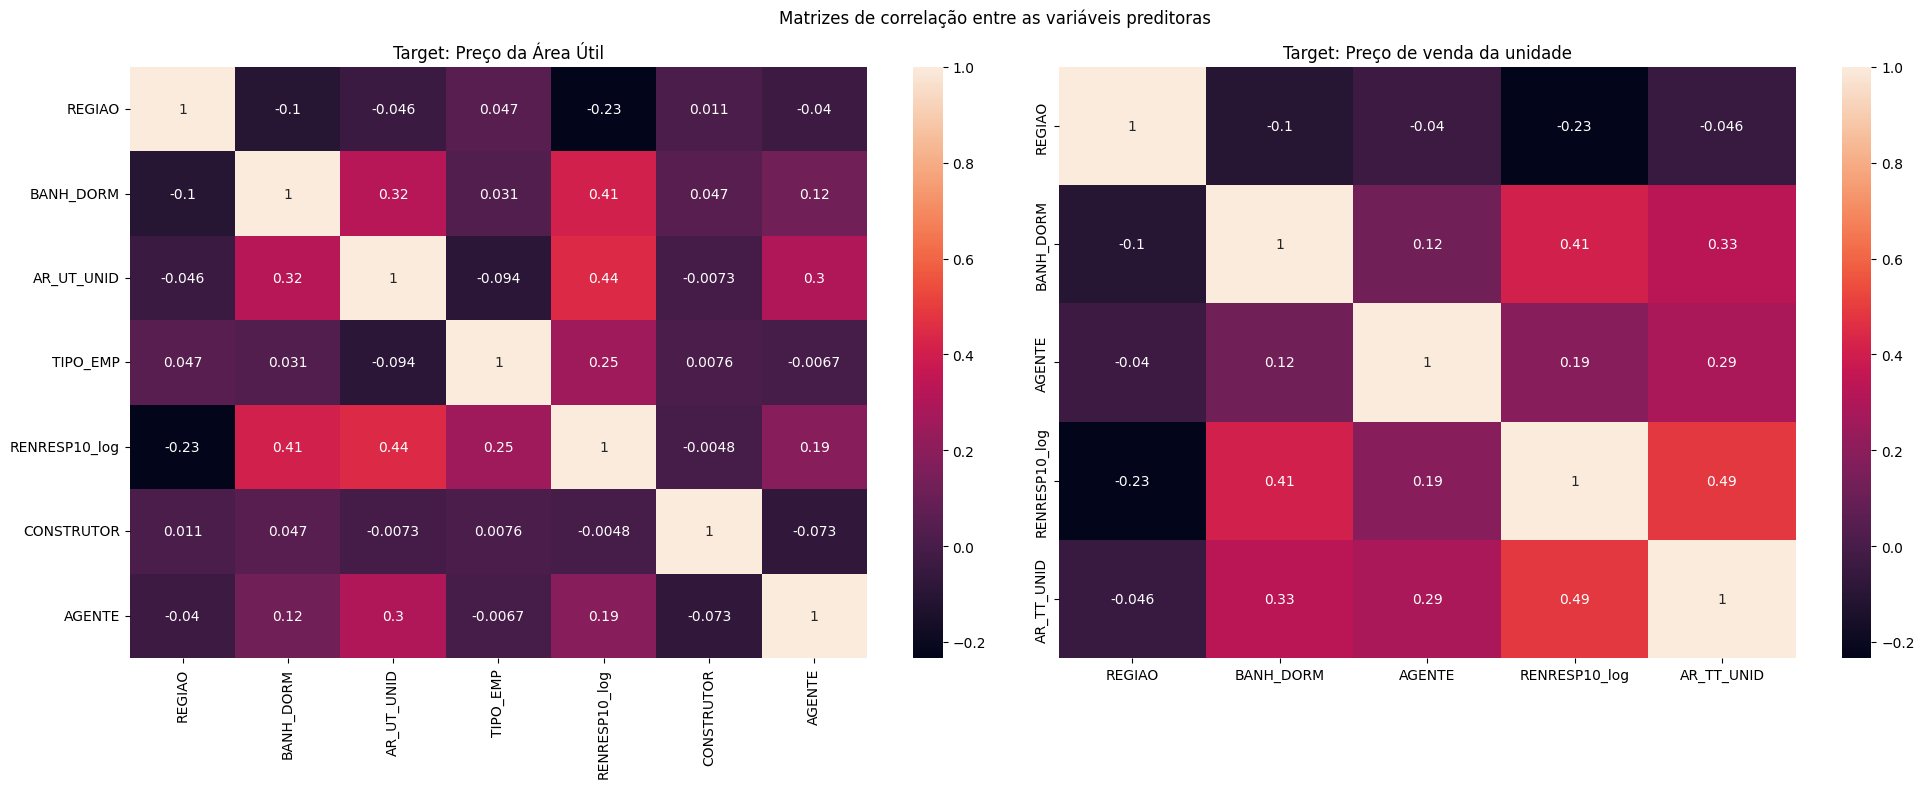

In [653]:
fig, axs = plt.subplots(1, 2, figsize=(20,8), facecolor='white') 
axs1 = sns.heatmap(df[variaveis_au].corr(), annot=True, ax=axs[0])
axs2 = sns.heatmap(df[variaveis_venda].corr(), annot=True, ax=axs[1])

axs1.set_title(label='Target: Preço da Área Útil')
axs2.set_title(label='Target: Preço de venda da unidade')
fig.suptitle('Matrizes de correlação entre as variáveis preditoras')
fig.tight_layout()

In [654]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif_tt = calc_vif(df[variaveis_venda])
print('vars: ', variaveis_venda)
print('Variable Inflation Factors:', vif_tt.VIF.sum(), '\n')

vif_au = calc_vif(df[variaveis_au])
print('vars: ', variaveis_au)
print('Variable Inflation Factors:', vif_au.VIF.sum(), '\n')


vars:  ['REGIAO', 'BANH_DORM', 'AGENTE', 'RENRESP10_log', 'AR_TT_UNID']
Variable Inflation Factors: 52.46571408568083 

vars:  ['REGIAO', 'BANH_DORM', 'AR_UT_UNID', 'TIPO_EMP', 'RENRESP10_log', 'CONSTRUTOR', 'AGENTE']
Variable Inflation Factors: 71.95626135832397 



Text(0.51, 0.9, '(VIF - Valor da área útil: 71.96)')

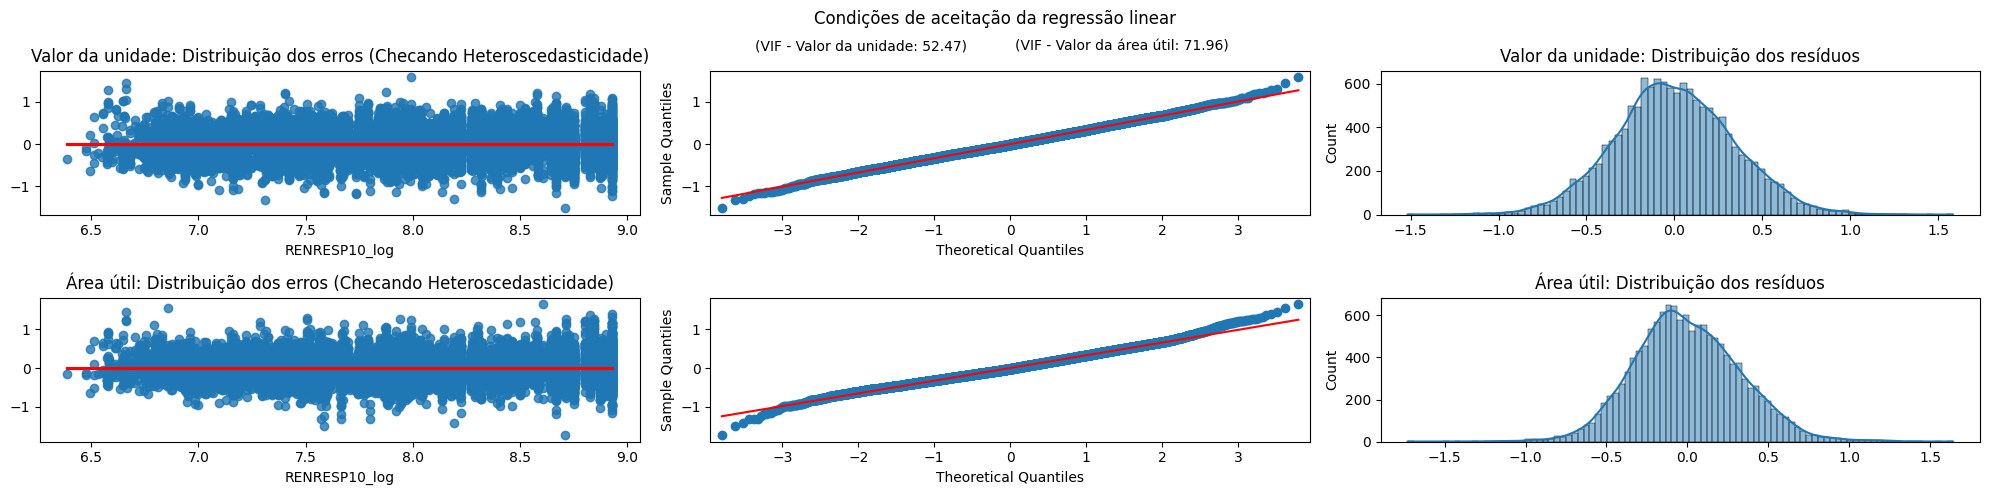

In [655]:
fig, axs = plt.subplots(2, 3, figsize=(20,5), facecolor='white') 
splot1 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_tt.resid, ax=axs[0,0], line_kws={'color':'red'})
splot2 = sma.qqplot(regressao_tt.resid, line="s", ax=axs[0,1])
splot3 = sns.histplot(regressao_tt.resid, kde=True, ax=axs[0,2])
splot4 = sns.regplot(x=X_train.RENRESP10_log, y=regressao_au_log.resid, ax=axs[1,0], line_kws={'color':'red'})
splot5 = sma.qqplot(regressao_au_log.resid, line="s", ax=axs[1,1])
splot6 = sns.histplot(regressao_au_log.resid, kde=True, ax=axs[1,2])

splot1.set_title('Valor da unidade: Distribuição dos erros (Checando Heteroscedasticidade)')
splot2.suptitle('Valor da unidade: Distribuição dos resíduos (QQPlot)')
splot3.set_title('Valor da unidade: Distribuição dos resíduos')
splot4.set_title('Área útil: Distribuição dos erros (Checando Heteroscedasticidade)')
splot5.suptitle('Área útil: Distribuição dos resíduos (QQPlot)')
splot6.set_title('Área útil: Distribuição dos resíduos')
fig.suptitle('Condições de aceitação da regressão linear')
fig.tight_layout()
fig.text(s='(VIF - Valor da unidade: {})'.format(round(vif_tt.VIF.sum(), 2)), y=0.90, x=0.38)
fig.text(s='(VIF - Valor da área útil: {})'.format(round(vif_au.VIF.sum(), 2)), y=0.90, x=0.51)

<>3 - Modelo Random Forest<>

In [656]:
num_pipeline = Pipeline(steps=[
    ("input", SimpleImputer()),
    ('scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline(steps=[
    ("cat", OneHotEncoder(handle_unknown= 'ignore'))
    ])

#TRANSFORMANDO COLUNAS
preprocessing = ColumnTransformer(transformers=[
    ('preprocessamento numerico', num_pipeline, numericas2),
    ('preprocessamento categorico', cat_pipeline, categoricas2)
])

In [657]:
len(X_train.columns.to_list())

62

In [668]:

for n_estimadores in [1, 5, 10, 20, 30, 50, 100, 200]:
    model = Pipeline(steps=[('Preprocessamento', preprocessing),
                            ('regressao', RandomForestRegressor(n_estimators=n_estimadores, max_features=0.3, max_depth=12))])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    print('estimadores: {}, RMSE: {}, Score: {}'.format(n_estimadores, rmse, model.score(X_test, y_test)))

estimadores: 1, RMSE: 0.2662674720567048, Score: 0.6849599134704578
estimadores: 5, RMSE: 0.21731246033591492, Score: 0.7901548938484921
estimadores: 10, RMSE: 0.20974695605884627, Score: 0.8045116317269745
estimadores: 20, RMSE: 0.20288172328364418, Score: 0.817099270309777
estimadores: 30, RMSE: 0.2023343906279813, Score: 0.8180847953322515
estimadores: 50, RMSE: 0.19900231833747145, Score: 0.8240270722678982
estimadores: 100, RMSE: 0.1984428769970575, Score: 0.8250150823921532
estimadores: 200, RMSE: 0.19910489662154685, Score: 0.8238456105298569


In [664]:
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [35]:
feature_importances = model[1][1].feature_importances_

In [36]:
permutation_result = permutation_importance(model, X_test, y_test, n_repeats=30)

In [37]:
df_importancia = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
df_importancia.sort_values(by='importance', ascending=False, inplace=True)

Text(0.5, 0.98, 'Variáveis mais importantes no entendimento dos valores de residências vendidas')

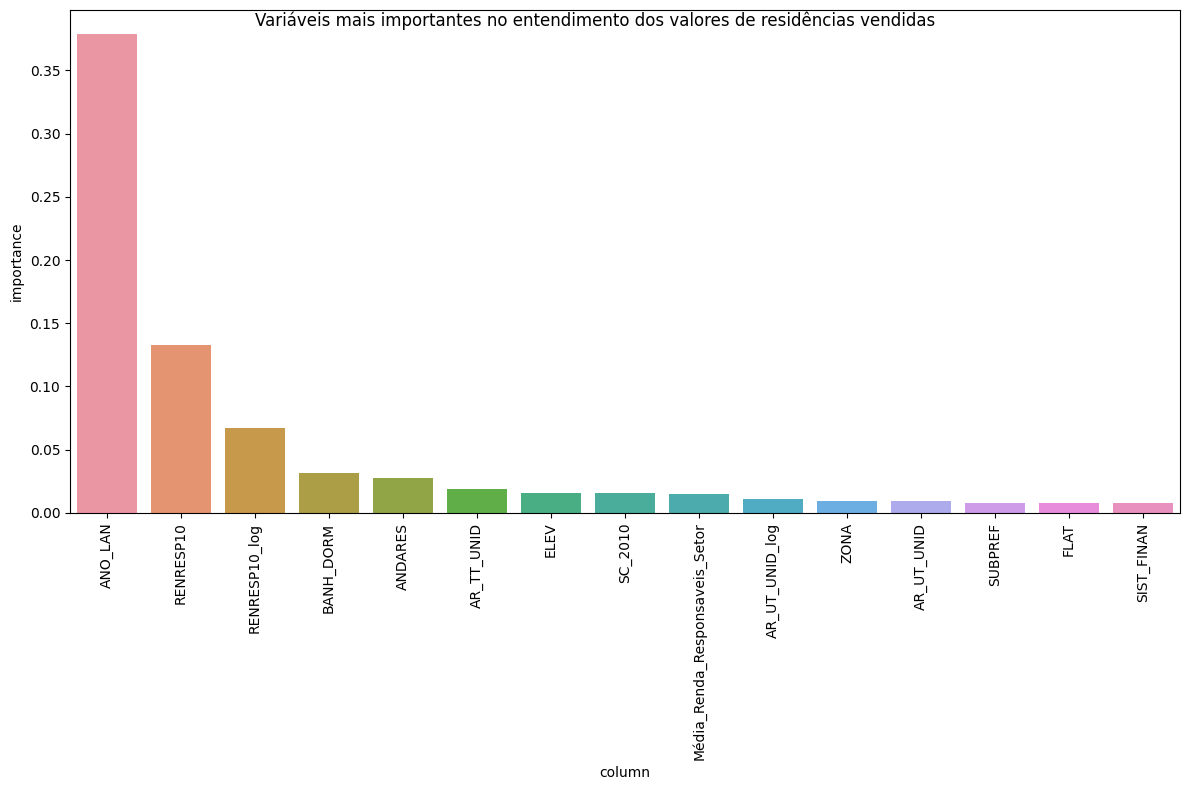

In [38]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='white')
ax = sns.barplot(x='column', y="importance", data=df_importancia.nlargest(15, 'importance'))
plt.xticks(rotation=90)
plt.tight_layout()

fig.suptitle('Variáveis mais importantes no entendimento dos valores de residências vendidas')

Conjunto 1: 0.65 (RandomF), 0.39 (RegressãoL)
Conjunto IBGE: 0.53 (RandomF), 0.26 (RegressãoL)
Conjunto 1_log: 0.69 (RandomF), 0.40 (RegressãoL)

In [39]:
y_pred = model.predict(X_test)

In [40]:
baseline_report = imprimir_metricas(y_test, y_pred)
baseline_report

,metric,valid
0,RMSE,0.20
1,MAE,0.14
2,R^2,0.82
3,MAPE,0.02
4,Avg. target,8.53
5,Avg. Prediction,8.53
